https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python/texts/6134208-modeling-techniques

In [1]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 

import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 

In [3]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

In [4]:
import statsmodels.api as sm 

In [107]:
from statsmodels.tsa.stattools import adfuller

In [108]:
from matplotlib.pylab import rcParams 

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [139]:
from statsmodels.tsa.stattools import acf, pacf 

In [146]:
from statsmodels.tsa.arima_model import ARIMA

In [5]:
%matplotlib inline 

In [6]:
train=pd.read_csv("Train_SU63ISt.csv") 
test=pd.read_csv("Test_0qrQsBZ.csv")

train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 

train_original=train.copy() 
test_original=test.copy()

In [7]:
train.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [8]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

### Features

ID is the unique number given to each observation point.

Datetime is the time of each observation.

Count is the passenger count corresponding to each Datetime

In [9]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [10]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [11]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']


#Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
    
    

In [12]:
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

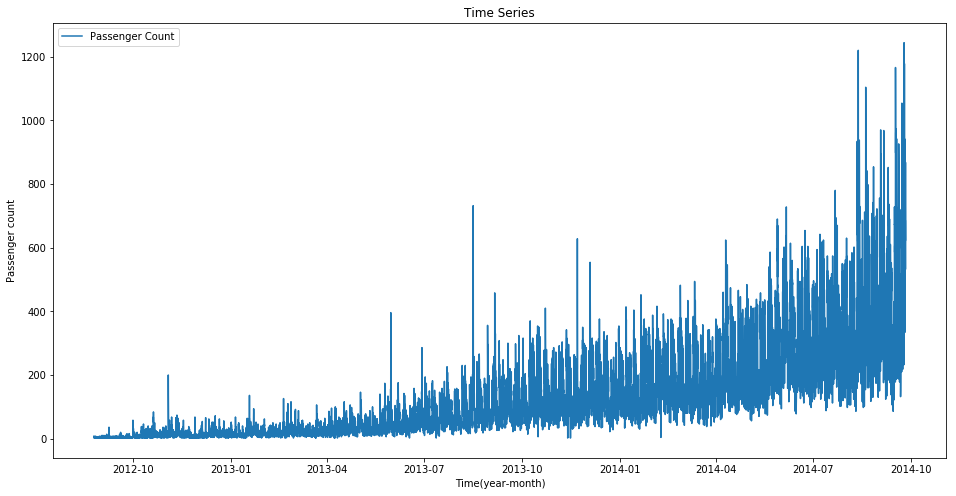

In [13]:
#Let’s look at the time series.

train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


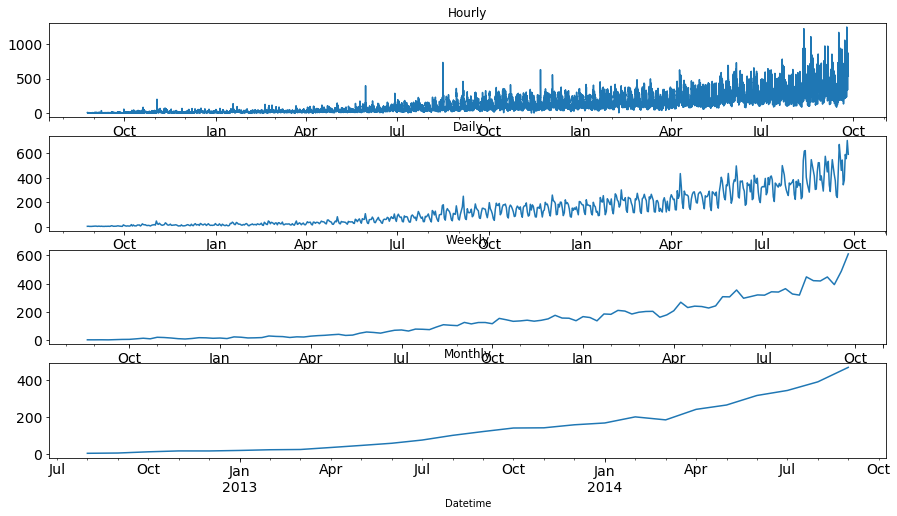

In [14]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()


#Let’s look at the hourly, daily, weekly and monthly time series.

fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 


In [15]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [16]:
test = test.resample('D').mean() 
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 


# Converting to daily mean 
train = train.resample('D').mean()



In [17]:
train.head()

,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [18]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']


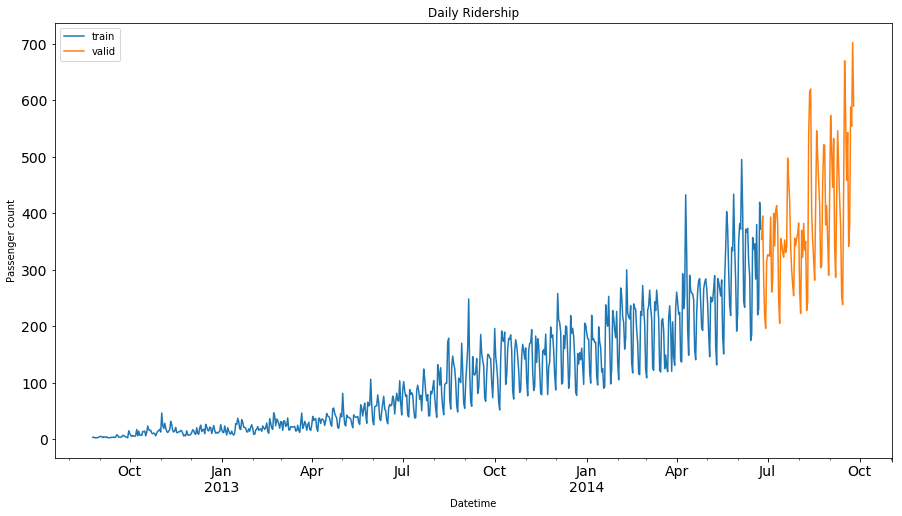

In [19]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()


In [20]:
dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 

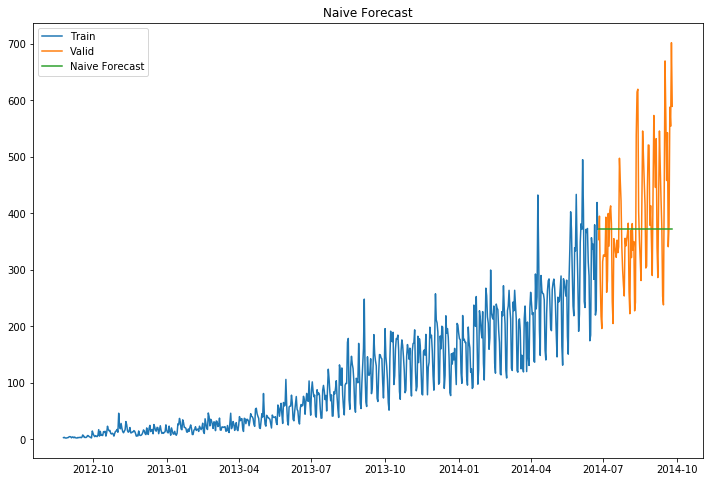

In [21]:
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [22]:
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


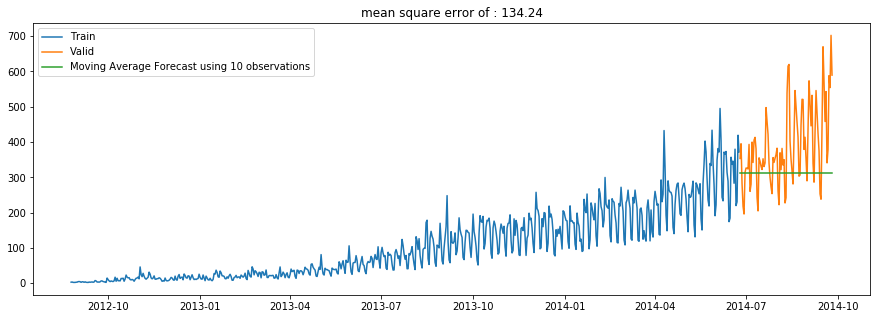

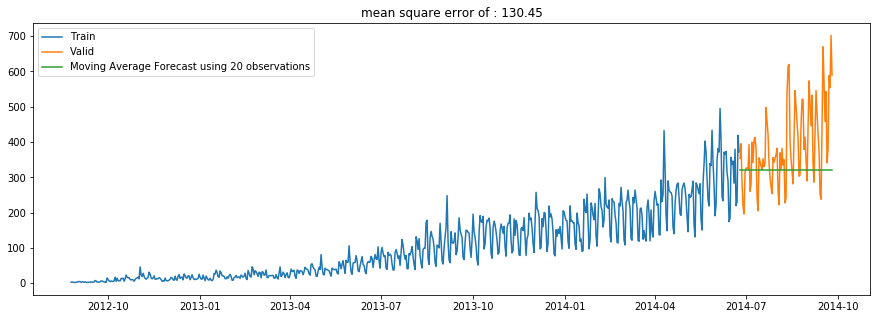

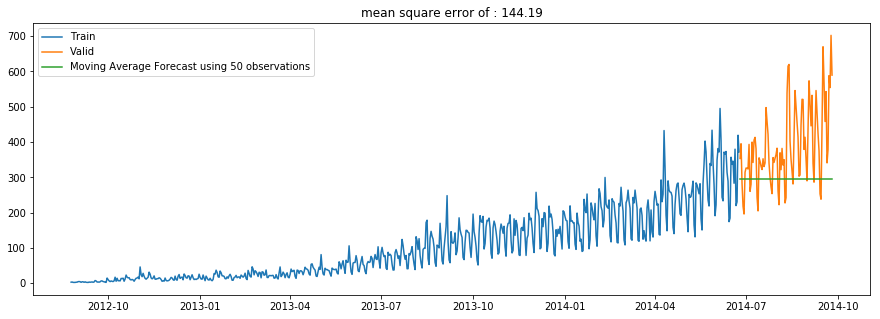

In [23]:
for ra in [10,20,50]:
    y_hat_avg = valid.copy() 
    y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(ra).mean().iloc[-1] # average of last 10 observations.
    rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
    
    
    plt.figure(figsize=(15,5)) 
    plt.plot(Train['Count'], label='Train') 
    plt.plot(valid['Count'], label='Valid') 
    plt.plot(y_hat_avg['moving_avg_forecast'], 
             label='Moving Average Forecast using {0} observations'.format(ra)) 
    plt.title('mean square error of : {0}'.format(round(rms,2)))
    plt.legend(loc='best') 
    plt.show() 


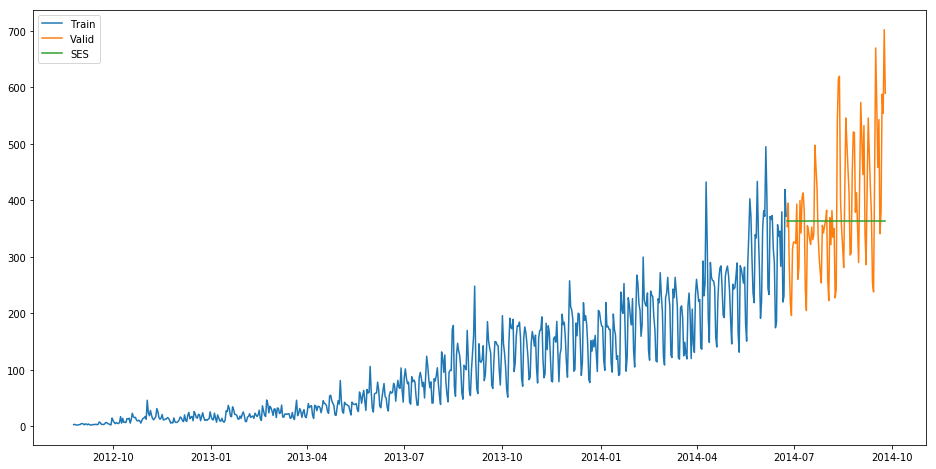

In [24]:

y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()


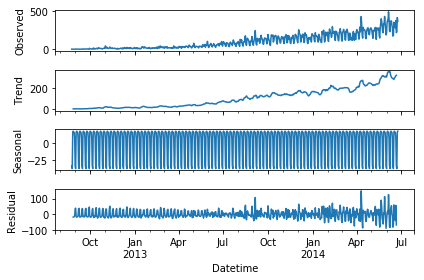

In [25]:
sm.tsa.seasonal_decompose(Train.Count).plot() 
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

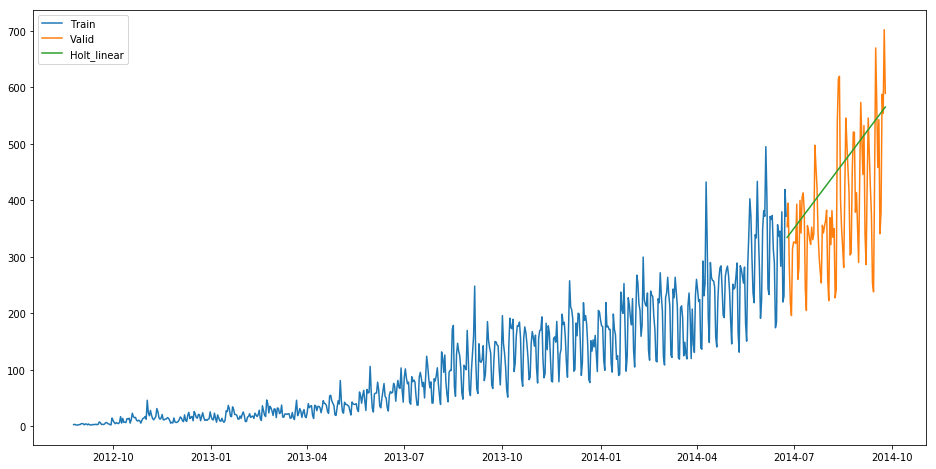

In [26]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [27]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


In [30]:
submission=pd.read_csv("Sample_Submission_QChS6c3.csv")

In [32]:
predict=fit1.forecast(len(test))

In [42]:
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

# Calculating the hourly ratio of count train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

# Grouping the hourly ratio 
temp=train_original.groupby(['Hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 

temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour.1',1) 

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale prediction['Count']=prediction['prediction']*prediction['ratio']*24 prediction['ID']=prediction['ID_y']
#Let’s drop all other features from the submission file and keep ID and Count only.

submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1) 
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

#Holt’s linear model gave rmse of 274.1596 on the leaderboard.

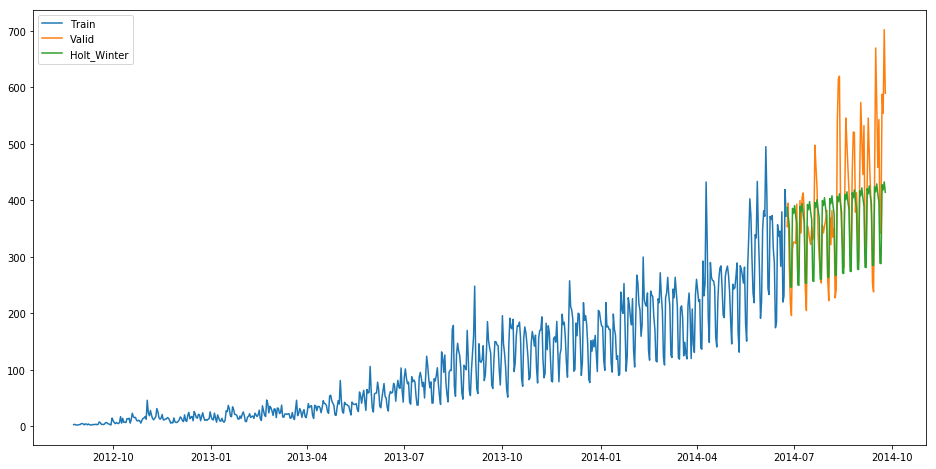

In [76]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()


In [49]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)

82.37533999199195


In [50]:
predict=fit1.forecast(len(test))

In [53]:
test['prediction']=predict

In [55]:
merge['Hour']=merge['Hour_y'] 

In [54]:
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')

In [56]:
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

In [60]:
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

In [61]:
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [101]:
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

In [102]:
submission.head()

,Count,ID
0,411.719511,18288
1,328.573710,18289
2,278.074562,18290
3,229.763076,18291
4,193.392275,18292


In [105]:
submission.to_csv('Holt winters.csv', index=False)

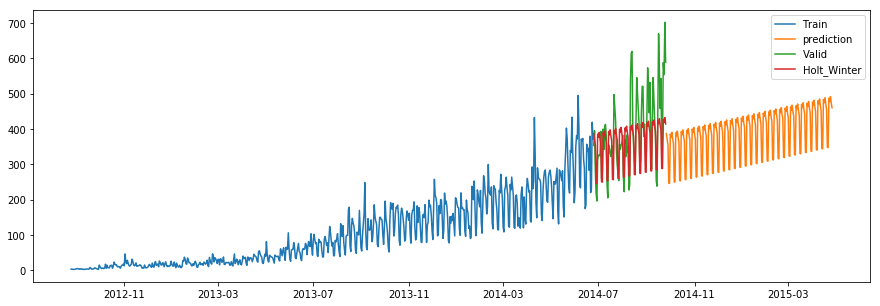

In [87]:
plt.figure(figsize=(15,5))

plt.plot( Train['Count'], label='Train')
plt.plot(test['prediction'], label = 'prediction')
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [117]:
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [122]:
rcParams['figure.figsize'] = 15,7

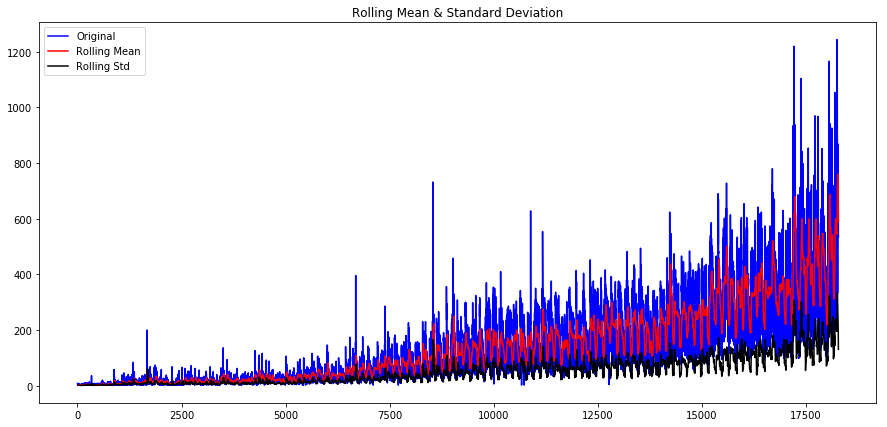

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [123]:
test_stationarity(train_original['Count'])

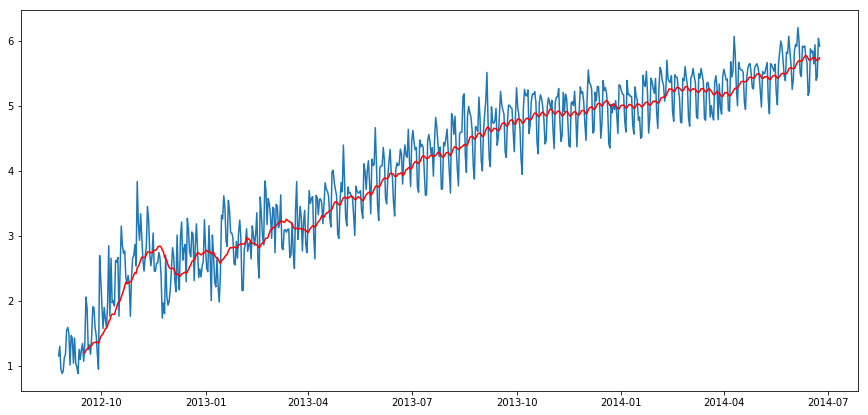

In [125]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

In [126]:
train_log_moving_avg_diff = Train_log - moving_avg

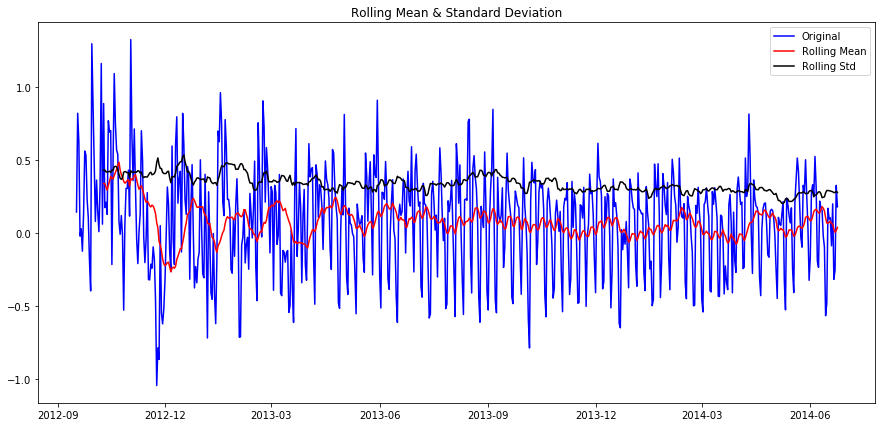

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [128]:
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

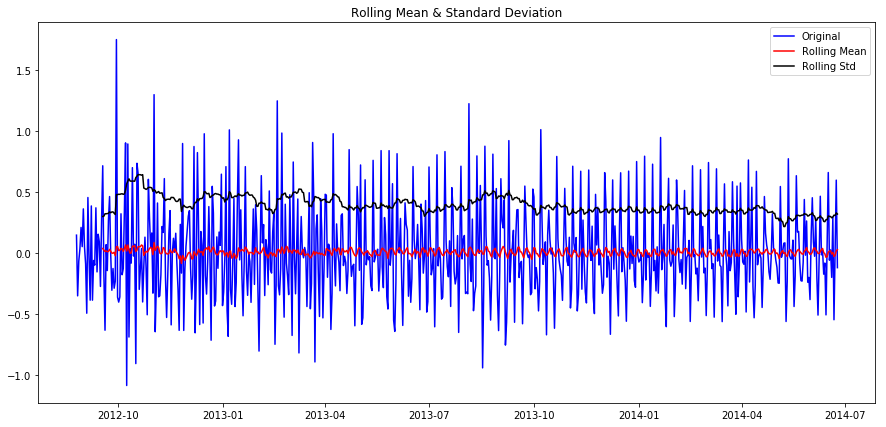

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [129]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

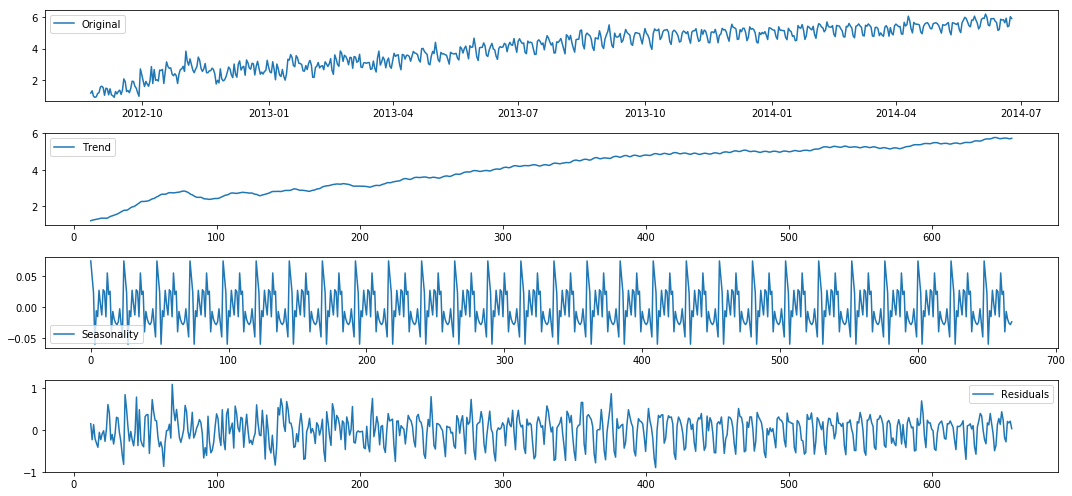

In [131]:

decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()


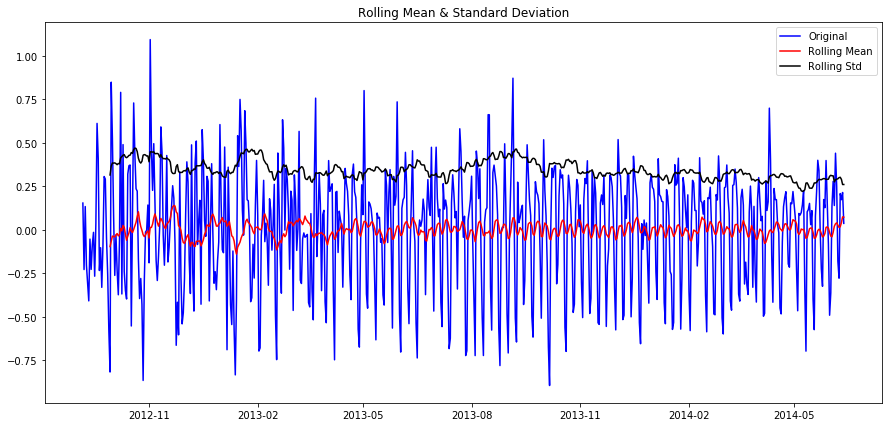

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [142]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

In [143]:
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


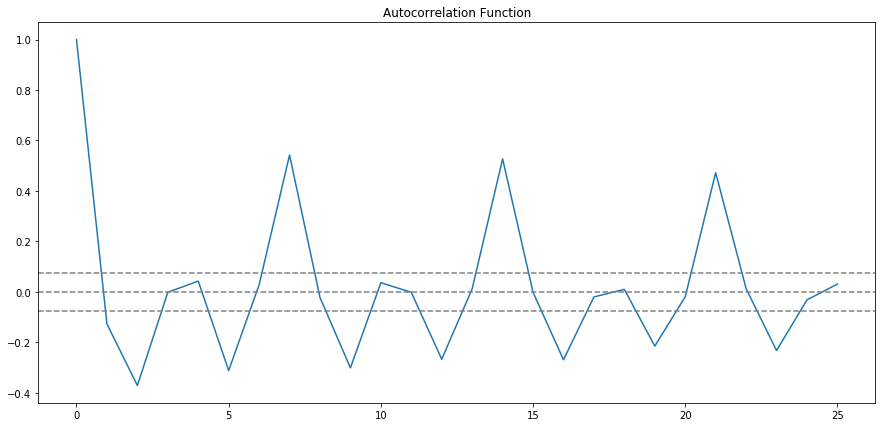

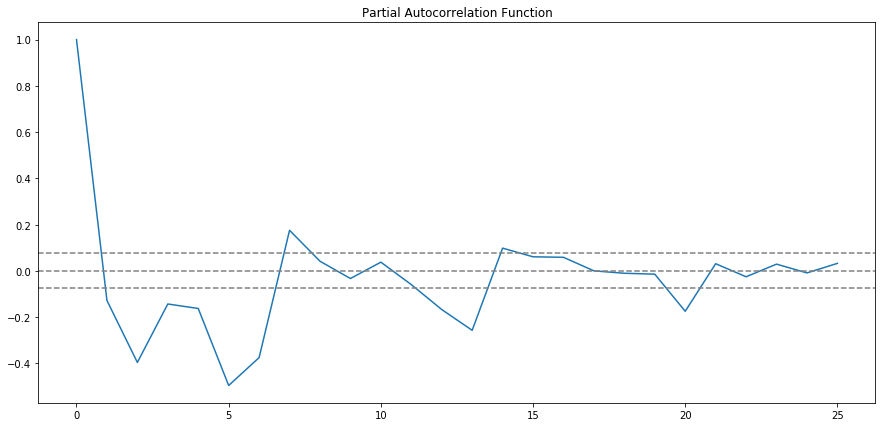

In [145]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()


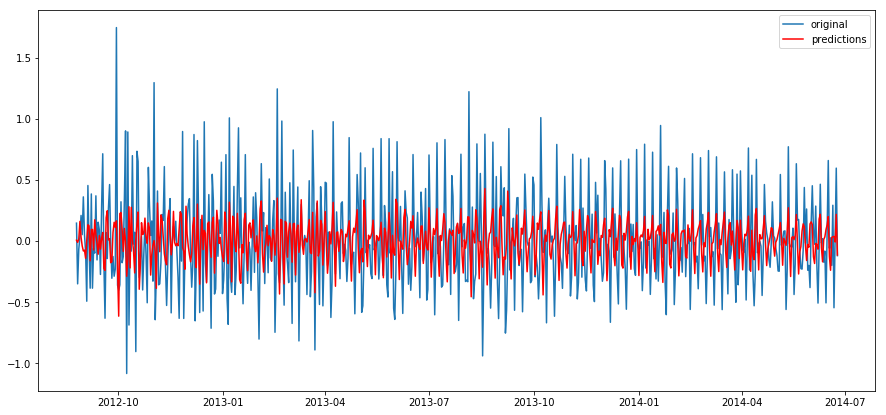

In [147]:
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

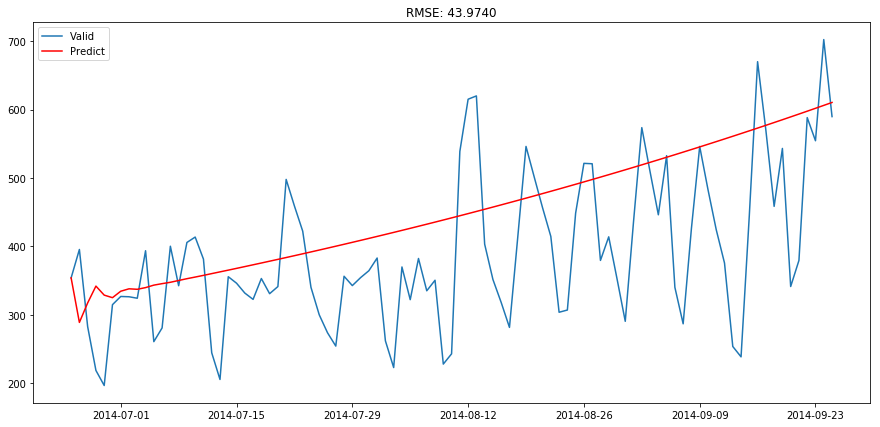

In [149]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()

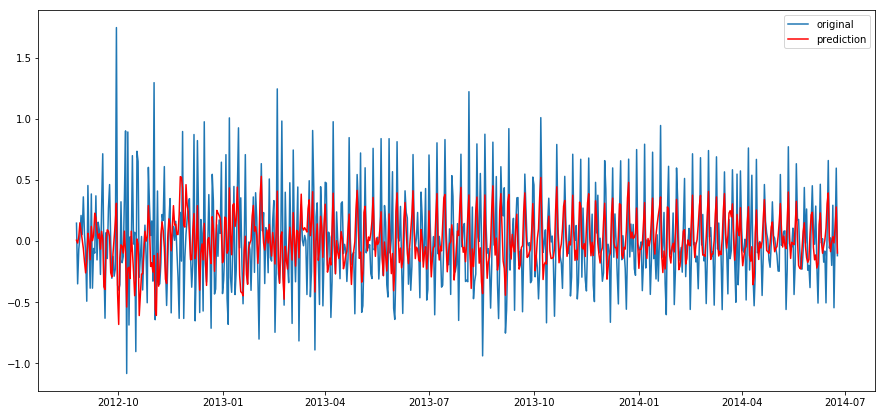

In [150]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

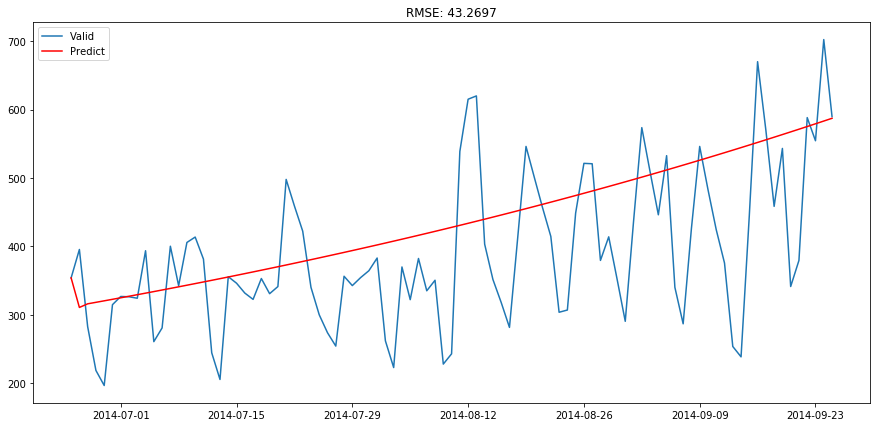

In [152]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()